In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pydot
from IPython.display import SVG, display
import pydrake
from pydrake.examples import PendulumPlant
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import PidController
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

builder = DiagramBuilder()

# First add the pendulum.
pendulum = builder.AddNamedSystem("pendulum", PendulumPlant())

# Add a PID controller.
controller = builder.AddNamedSystem("controller",
                                    PidController(kp=[10.], ki=[1.], kd=[1.]))

# Now "wire up" the controller to the plant.
builder.Connect(pendulum.get_state_output_port(),
                controller.get_input_port_estimated_state())
builder.Connect(controller.get_output_port_control(), pendulum.get_input_port())

# Make the desired_state input of the controller an input to the diagram.
builder.ExportInput(controller.get_input_port_desired_state())
# Make the pendulum state an output from the diagram.
builder.ExportOutput(pendulum.get_state_output_port())

# Log the state of the pendulum.
logger = LogVectorOutput(pendulum.get_state_output_port(), builder)
logger.set_name("logger")

diagram = builder.Build()
diagram.set_name("diagram")

# Visualize the diagram.
display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

FileNotFoundError: [Errno 2] "dot" not found in path.

Text(0.5, 1.0, 'PID Control of the Pendulum')

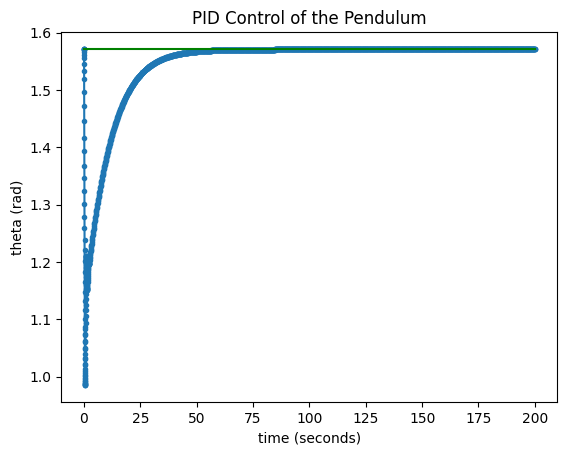

In [9]:
# Set up a simulator to run this diagram.
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

# We'll try to regulate the pendulum to a particular angle.
desired_angle = np.pi/2.

# First we extract the subsystem context for the pendulum.
pendulum_context = diagram.GetMutableSubsystemContext(pendulum, context)
# Then we can set the pendulum state, which is (theta, thetadot).
pendulum_context.get_mutable_continuous_state_vector().SetFromVector(
    [desired_angle, 0.2])

# The diagram has a single input port (port index 0), which is the desired_state.
diagram.get_input_port(0).FixValue(context, [desired_angle, 0.])

# Clear the logger only because we've written this notebook with the opportunity to
# simulate multiple times (in this cell) using the same logger object.  This is
# often not needed.
logger.FindMutableLog(context).Clear()

# Simulate for 10 seconds.
simulator.AdvanceTo(200)

# Plot the results.
log = logger.FindLog(simulator.get_context())
t = log.sample_times()
plt.figure()
# Plot theta.
plt.plot(t, log.data()[0,:],'.-')
# Draw a line for the desired angle.
plt.plot([t[0], t[-1]], [desired_angle, desired_angle], 'g' )
plt.xlabel('time (seconds)')
plt.ylabel('theta (rad)')
plt.title('PID Control of the Pendulum')